# Final Project Baseline: House Prices- Advanced Regression Techniques
### Author: Radia Abdul Wahab, Parham Motameni, Jun Qian
### Date: Fall 2021
### Course: w207 Machine Learning






## Supplementary Notebook for PCA assessment, and its effect on Random Forest Regressor

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import time
import random
import scipy.io as sio
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# sklearn
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV



# internal modules
from base_regressor_plot import BaseRegressorPlot
from configurations import args
from data_loader import DataLoader
from elastic_net_regressor import ElasticNetRegressor
from decision_tree_regressor import DecisionTreeRegressor
from lasso_regressor import LassoRegressor
from linear_regressor import LinearRegressor
from random_forest_regressor import RandomForestRegressor
from ridge_regressor import RidgeRegressor
#from neuralnetwork import create_nn_regressor

%matplotlib inline


warnings.filterwarnings('ignore')




In [2]:
# download data file if it is not ready
data_file = Path(args.data_path)
if data_file.is_file():
    print("Datafile is already loaded.")
else:
    !curl -L "https://drive.google.com/uc?export=download&id=1ortEJfmlpt9-dbg5f6cTDt5nicswf5wT" > 'test.csv'
    !curl -L "https://drive.google.com/uc?export=download&id=1EG5jP5RDEIsNAMaF2m42KOyz-ZVjC8wS" > 'train.csv'
data_loader = DataLoader(args)
df = data_loader.df

Datafile is already loaded.


In [3]:
# lock the seed to have repeatable results
random.seed(100)

In [4]:
missing=df.isnull().sum().sort_values(ascending=False).head(20)
missing

#######New

missing = missing[missing > 0]
percent_missing = missing * 100 / df.shape[0]
pd.concat([missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage Missing']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage Missing
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageQual,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945


In [5]:
# Fill missing value of 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu' as NonExist. Leave LotFrontage for further investigation
df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']]=df[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].fillna('NonExist')
missing_with_replace=df.isnull().sum().sort_values(ascending=False).head(20)
missing_with_replace

#######New

missing_with_replace = missing_with_replace[missing_with_replace > 0]
percent_missing = missing_with_replace * 100 / df.shape[0]
pd.concat([missing_with_replace, percent_missing], axis=1, 
          keys=['Missing Values After filling Non_Exist', 'Percentage Missing']).\
          sort_values(by="Missing Values After filling Non_Exist", ascending=False)

,Missing Values After filling Non_Exist,Percentage Missing
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
BsmtExposure,38,2.602740
BsmtFinType2,38,2.602740
BsmtFinType1,37,2.534247
BsmtCond,37,2.534247


In [6]:
# Create train, dev, test datasets

# split data into Test and train
X_train, X_test, y_train, y_test = train_test_split(
    data_loader.df_X, data_loader.df_y, test_size= 0.10, random_state=1)

print(len(X_train),len( X_test))

# TODO split more to dev set if needed!

"""
train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio)) 

print(len(X_train), len(X_val),len( X_test))

"""

1314 146


'\ntrain_ratio = 0.90\nvalidation_ratio = 0.05\ntest_ratio = 0.05\n\nX_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio)) \n\nprint(len(X_train), len(X_val),len( X_test))\n\n'

## Initial Look at the data:

In [7]:
print(f'X_train size: {X_train.shape}, X_test size: {X_test.shape}')
print(f'y_train size: {y_train.shape}, y_test size: {y_test.shape}')
X_train.head()

X_train size: (1314, 79), X_test size: (146, 79)
y_train size: (1314, 1), y_test size: (146, 1)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
418,50,RL,60.0,8160,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2007,WD,AdjLand
782,20,RL,67.0,16285,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
1338,60,RL,95.0,13450,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
931,20,RL,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,7,2009,WD,Normal
780,20,RL,63.0,7875,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal


## Run PCA

In [8]:
df_PCA_train=y_train.merge(X_train, how="inner",left_index=True,right_index=True)
df_PCA_test=y_test.merge(X_test, how="inner",left_index=True,right_index=True)

In [9]:
df_PCA_numeric_train=df_PCA_train._get_numeric_data()
df_PCA_numeric_train

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
418,126000,50,60.0,8160,5,6,1940,1950,0.0,312,...,240,0,0,0,0,0,0,0,4,2007
782,187100,20,67.0,16285,7,5,2001,2002,0.0,0,...,605,0,33,0,0,0,0,0,6,2009
1338,200000,60,95.0,13450,7,5,2002,2002,0.0,700,...,492,146,91,0,0,0,0,0,6,2006
931,117500,20,70.0,9100,5,6,1965,1965,0.0,338,...,429,0,0,0,0,0,0,0,7,2009
780,176000,20,63.0,7875,7,5,1995,1996,38.0,0,...,402,220,21,0,0,0,0,0,6,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,165000,20,78.0,10140,6,5,1974,1974,174.0,0,...,478,0,0,0,0,0,0,0,8,2009
905,128000,20,80.0,9920,5,5,1954,1954,110.0,354,...,280,0,0,164,0,0,0,0,2,2010
1096,127000,70,60.0,6882,6,7,1914,2006,0.0,0,...,0,136,0,115,0,0,0,0,3,2007
235,89500,160,21.0,1680,6,3,1971,1971,604.0,358,...,264,0,0,0,0,0,0,0,8,2008


In [10]:
df_PCA_numeric_test=df_PCA_test._get_numeric_data()
df_PCA_numeric_test

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
258,231500,60,80.0,12435,7,5,2001,2001,172.0,361,...,564,0,96,0,245,0,0,0,5,2008
267,179500,75,60.0,8400,5,8,1939,1997,0.0,378,...,240,262,24,0,0,0,0,0,7,2008
288,122000,20,NaN,9819,5,5,1967,1967,31.0,450,...,280,0,0,0,0,0,0,0,2,2010
649,84500,180,21.0,1936,4,6,1970,1970,0.0,131,...,0,0,0,0,0,0,0,0,12,2007
1233,142000,20,NaN,12160,5,5,1959,1959,180.0,1000,...,531,0,0,0,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,272000,60,NaN,12227,6,7,1977,1995,424.0,896,...,619,550,282,0,0,0,0,0,7,2008
919,176500,20,87.0,11029,6,8,1958,2002,0.0,528,...,601,0,51,0,0,190,0,0,5,2008
559,234000,120,NaN,3196,7,5,2003,2004,18.0,0,...,420,143,20,0,0,0,0,0,10,2006
30,40000,70,50.0,8500,4,4,1920,1950,0.0,0,...,250,0,54,172,0,0,0,0,7,2008


In [11]:
df_PCA_numeric_train2=df_PCA_numeric_train[df_PCA_numeric_train["GrLivArea"] < 4000]
df_PCA_numeric_train2

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
418,126000,50,60.0,8160,5,6,1940,1950,0.0,312,...,240,0,0,0,0,0,0,0,4,2007
782,187100,20,67.0,16285,7,5,2001,2002,0.0,0,...,605,0,33,0,0,0,0,0,6,2009
1338,200000,60,95.0,13450,7,5,2002,2002,0.0,700,...,492,146,91,0,0,0,0,0,6,2006
931,117500,20,70.0,9100,5,6,1965,1965,0.0,338,...,429,0,0,0,0,0,0,0,7,2009
780,176000,20,63.0,7875,7,5,1995,1996,38.0,0,...,402,220,21,0,0,0,0,0,6,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,165000,20,78.0,10140,6,5,1974,1974,174.0,0,...,478,0,0,0,0,0,0,0,8,2009
905,128000,20,80.0,9920,5,5,1954,1954,110.0,354,...,280,0,0,164,0,0,0,0,2,2010
1096,127000,70,60.0,6882,6,7,1914,2006,0.0,0,...,0,136,0,115,0,0,0,0,3,2007
235,89500,160,21.0,1680,6,3,1971,1971,604.0,358,...,264,0,0,0,0,0,0,0,8,2008


In [12]:
df_PCA_numeric_test2=df_PCA_numeric_test[df_PCA_numeric_test["GrLivArea"] < 4000]
df_PCA_numeric_test2

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
258,231500,60,80.0,12435,7,5,2001,2001,172.0,361,...,564,0,96,0,245,0,0,0,5,2008
267,179500,75,60.0,8400,5,8,1939,1997,0.0,378,...,240,262,24,0,0,0,0,0,7,2008
288,122000,20,NaN,9819,5,5,1967,1967,31.0,450,...,280,0,0,0,0,0,0,0,2,2010
649,84500,180,21.0,1936,4,6,1970,1970,0.0,131,...,0,0,0,0,0,0,0,0,12,2007
1233,142000,20,NaN,12160,5,5,1959,1959,180.0,1000,...,531,0,0,0,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,272000,60,NaN,12227,6,7,1977,1995,424.0,896,...,619,550,282,0,0,0,0,0,7,2008
919,176500,20,87.0,11029,6,8,1958,2002,0.0,528,...,601,0,51,0,0,190,0,0,5,2008
559,234000,120,NaN,3196,7,5,2003,2004,18.0,0,...,420,143,20,0,0,0,0,0,10,2006
30,40000,70,50.0,8500,4,4,1920,1950,0.0,0,...,250,0,54,172,0,0,0,0,7,2008


In [13]:
df_SalePrice_train=df_PCA_numeric_train2['SalePrice']
df_SalePrice_train

418     126000
782     187100
1338    200000
931     117500
780     176000
         ...  
715     165000
905     128000
1096    127000
235      89500
1061     81000
Name: SalePrice, Length: 1310, dtype: int64

In [14]:
df_SalePrice_test=df_PCA_numeric_test2['SalePrice']
df_SalePrice_test

258     231500
267     179500
288     122000
649      84500
1233    142000
         ...  
961     272000
919     176500
559     234000
30       40000
382     213500
Name: SalePrice, Length: 146, dtype: int64

In [15]:
df_PCA_numeric_train2=df_PCA_numeric_train2.drop('SalePrice', 1)
df_PCA_numeric_train2

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
418,50,60.0,8160,5,6,1940,1950,0.0,312,0,...,240,0,0,0,0,0,0,0,4,2007
782,20,67.0,16285,7,5,2001,2002,0.0,0,0,...,605,0,33,0,0,0,0,0,6,2009
1338,60,95.0,13450,7,5,2002,2002,0.0,700,0,...,492,146,91,0,0,0,0,0,6,2006
931,20,70.0,9100,5,6,1965,1965,0.0,338,466,...,429,0,0,0,0,0,0,0,7,2009
780,20,63.0,7875,7,5,1995,1996,38.0,0,0,...,402,220,21,0,0,0,0,0,6,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,20,78.0,10140,6,5,1974,1974,174.0,0,0,...,478,0,0,0,0,0,0,0,8,2009
905,20,80.0,9920,5,5,1954,1954,110.0,354,290,...,280,0,0,164,0,0,0,0,2,2010
1096,70,60.0,6882,6,7,1914,2006,0.0,0,0,...,0,136,0,115,0,0,0,0,3,2007
235,160,21.0,1680,6,3,1971,1971,604.0,358,0,...,264,0,0,0,0,0,0,0,8,2008


In [16]:
df_PCA_numeric_test2=df_PCA_numeric_test2.drop('SalePrice', 1)
df_PCA_numeric_test2

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
258,60,80.0,12435,7,5,2001,2001,172.0,361,0,...,564,0,96,0,245,0,0,0,5,2008
267,75,60.0,8400,5,8,1939,1997,0.0,378,0,...,240,262,24,0,0,0,0,0,7,2008
288,20,NaN,9819,5,5,1967,1967,31.0,450,0,...,280,0,0,0,0,0,0,0,2,2010
649,180,21.0,1936,4,6,1970,1970,0.0,131,499,...,0,0,0,0,0,0,0,0,12,2007
1233,20,NaN,12160,5,5,1959,1959,180.0,1000,0,...,531,0,0,0,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,60,NaN,12227,6,7,1977,1995,424.0,896,0,...,619,550,282,0,0,0,0,0,7,2008
919,20,87.0,11029,6,8,1958,2002,0.0,528,411,...,601,0,51,0,0,190,0,0,5,2008
559,120,NaN,3196,7,5,2003,2004,18.0,0,0,...,420,143,20,0,0,0,0,0,10,2006
30,70,50.0,8500,4,4,1920,1950,0.0,0,0,...,250,0,54,172,0,0,0,0,7,2008


In [17]:
missing=df_PCA_numeric_train2.isnull().sum().sort_values(ascending=False).head(20)
missing

#######New

missing = missing[missing > 0]
percent_missing = missing * 100 / df.shape[0]
pd.concat([missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage Missing']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage Missing
LotFrontage,233,15.958904
GarageYrBlt,73,5.000000
MasVnrArea,8,0.547945


In [18]:
missing=df_PCA_numeric_test2.isnull().sum().sort_values(ascending=False).head(20)
missing

#######New

missing = missing[missing > 0]
percent_missing = missing * 100 / df.shape[0]
pd.concat([missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage Missing']).\
          sort_values(by="Missing Values", ascending=False)

,Missing Values,Percentage Missing
LotFrontage,26,1.780822
GarageYrBlt,8,0.547945


In [19]:
# Fill missing value of 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu' as NonExist. Leave LotFrontage for further investigation
df_PCA_numeric_train2[['LotFrontage','GarageYrBlt','MasVnrArea']]=df_PCA_numeric_train2[['LotFrontage','GarageYrBlt','MasVnrArea']].fillna('0')
missing_with_replace=df_PCA_numeric_train2.isnull().sum().sort_values(ascending=False).head(20)
missing_with_replace

#######New

missing_with_replace = missing_with_replace[missing_with_replace > 0]
percent_missing = missing_with_replace * 100 / df.shape[0]
pd.concat([missing_with_replace, percent_missing], axis=1, 
          keys=['Missing Values After filling Non_Exist', 'Percentage Missing']).\
          sort_values(by="Missing Values After filling Non_Exist", ascending=False)

,Missing Values After filling Non_Exist,Percentage Missing


In [20]:
# Fill missing value of 'PoolQC','MiscFeature','Alley','Fence','FireplaceQu' as NonExist. Leave LotFrontage for further investigation
df_PCA_numeric_test2[['LotFrontage','GarageYrBlt']]=df_PCA_numeric_test2[['LotFrontage','GarageYrBlt']].fillna('0')
missing_with_replace=df_PCA_numeric_test2.isnull().sum().sort_values(ascending=False).head(20)
missing_with_replace

#######New

missing_with_replace = missing_with_replace[missing_with_replace > 0]
percent_missing = missing_with_replace * 100 / df.shape[0]
pd.concat([missing_with_replace, percent_missing], axis=1, 
          keys=['Missing Values After filling Non_Exist', 'Percentage Missing']).\
          sort_values(by="Missing Values After filling Non_Exist", ascending=False)

,Missing Values After filling Non_Exist,Percentage Missing


k = 0  Variance = 0.9840775896490358
k = 1  Variance = 0.004284939107719216
k = 2  Variance = 0.0031479951023758853
k = 3  Variance = 0.002647275532995544
k = 4  Variance = 0.0025339181489037023
k = 5  Variance = 0.0018095318818272558
k = 6  Variance = 0.0004902057050702104
k = 7  Variance = 0.00029855242279112416
k = 8  Variance = 0.0002392933466967255
k = 9  Variance = 0.00016828868006481357
k = 10  Variance = 0.00012578239778153247
k = 11  Variance = 4.0078797942087566e-05
k = 12  Variance = 3.21785907672389e-05
k = 13  Variance = 2.878225103688164e-05
k = 14  Variance = 2.585027441171965e-05
k = 15  Variance = 1.5234628566316747e-05
k = 16  Variance = 9.733864929411868e-06
k = 17  Variance = 8.817336547944678e-06
k = 18  Variance = 8.40968247325267e-06
k = 19  Variance = 5.5455398343129126e-06
k = 20  Variance = 1.8815375232215666e-06
k = 21  Variance = 6.779487389765595e-08
k = 22  Variance = 1.571896212377057e-08
k = 23  Variance = 8.636921394844175e-09
k = 24  Variance = 7.85152

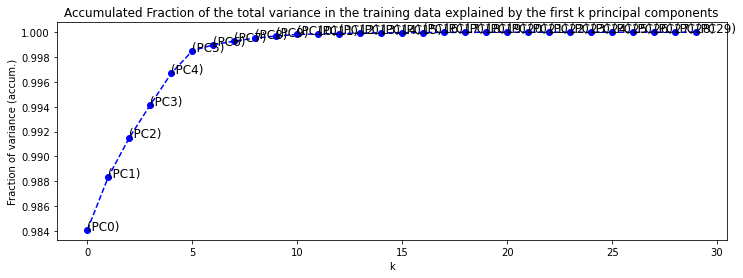

In [25]:
def PCA_Variance():
    principal_components=PCA()
    principal_components.fit(df_PCA_numeric_train2)
    
    K = range(30)
    for k in K:
        partial_variance_cumsum = principal_components.explained_variance_ratio_.cumsum()
        partial_variance = principal_components.explained_variance_ratio_
        
    for k in K:
        print ("k =", k, " Variance =", partial_variance[k])
 
    
    plt.figure(figsize=(12, 4))
    plt.plot(K, partial_variance_cumsum[K],'--bo')
    plt.title('Accumulated Fraction of the total variance in the training data explained by the first k principal components')
    plt.xlabel('k')
    plt.ylabel('Fraction of variance (accum.)')
    plt.axis()
    for i_x,i_y in zip(K,partial_variance_cumsum[K]):
        plt.text(i_x,i_y,'(PC{})'.format(i_x),fontsize = 12)
        
        
    plt.show() 
    
PCA_Variance()

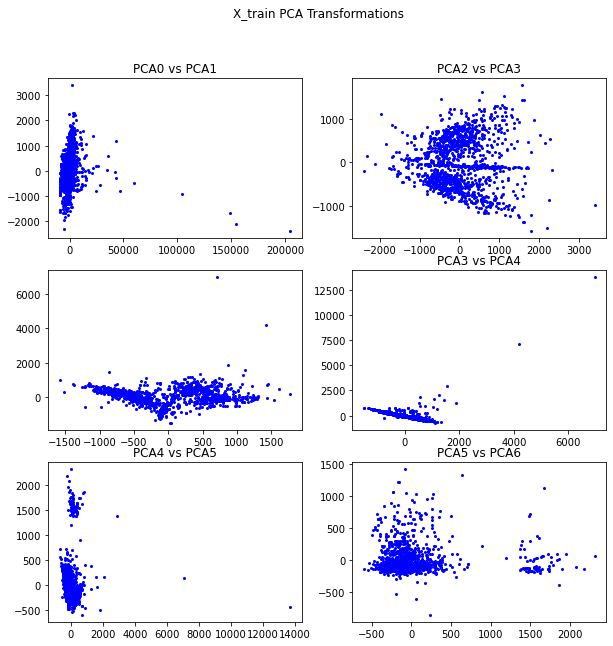

In [26]:
def PCA_variances_2D():   

    PCA_2D = PCA(n_components=10)

    PCA_transformed=PCA_2D.fit_transform(df_PCA_numeric_train2)

    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle('X_train PCA Transformations')
    axes[0, 0].plot(PCA_transformed[:,0],PCA_transformed[:,1], 'bo',markersize=2)
    axes[0, 0].set_title('PCA0 vs PCA1')
    
    axes[0, 1].plot(PCA_transformed[:,1], PCA_transformed[:,2], 'bo',markersize=2)
    axes[0, 1].set_title('PCA1 vs PCA2')

    axes[1, 0].plot(PCA_transformed[:,2], PCA_transformed[:,3], 'bo',markersize=2)
    axes[0, 1].set_title('PCA2 vs PCA3')

    axes[1, 1].plot(PCA_transformed[:,3], PCA_transformed[:,4], 'bo',markersize=2)
    axes[1, 1].set_title('PCA3 vs PCA4')
    
    axes[2, 0].plot(PCA_transformed[:,4], PCA_transformed[:,5], 'bo',markersize=2)
    axes[2, 0].set_title('PCA4 vs PCA5')
    
    axes[2, 1].plot(PCA_transformed[:,5], PCA_transformed[:,6], 'bo',markersize=2)
    axes[2, 1].set_title('PCA5 vs PCA6')
    
    plt.show()


PCA_variances_2D()

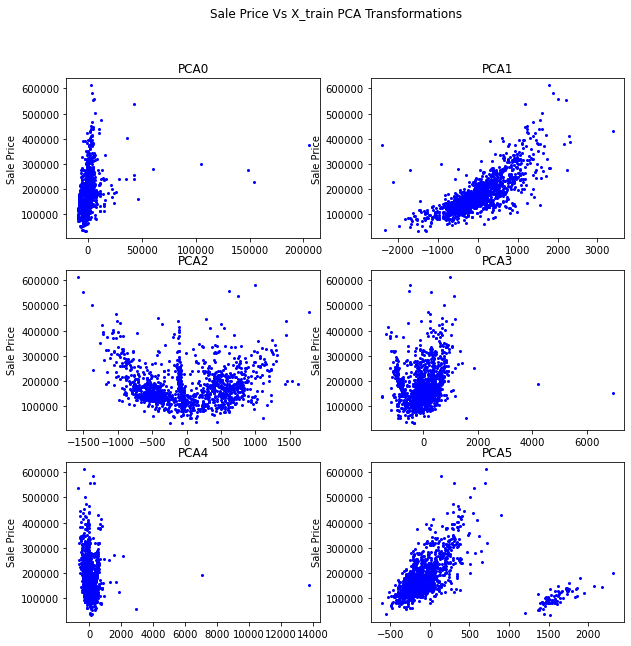

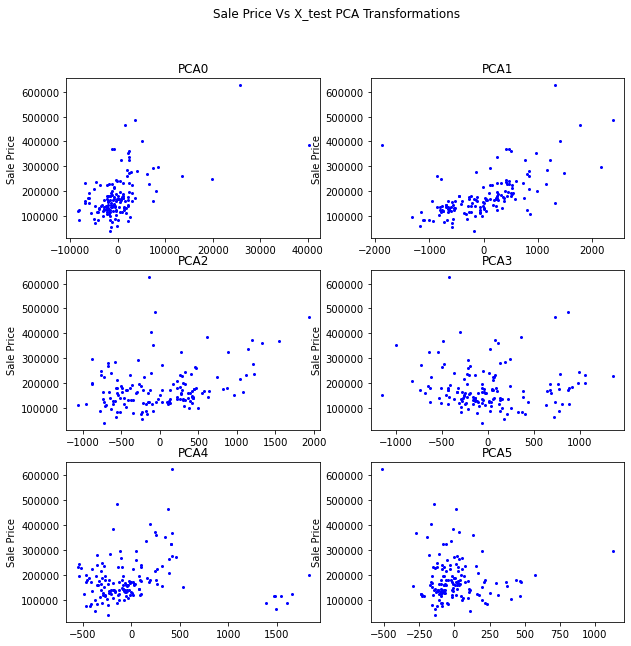

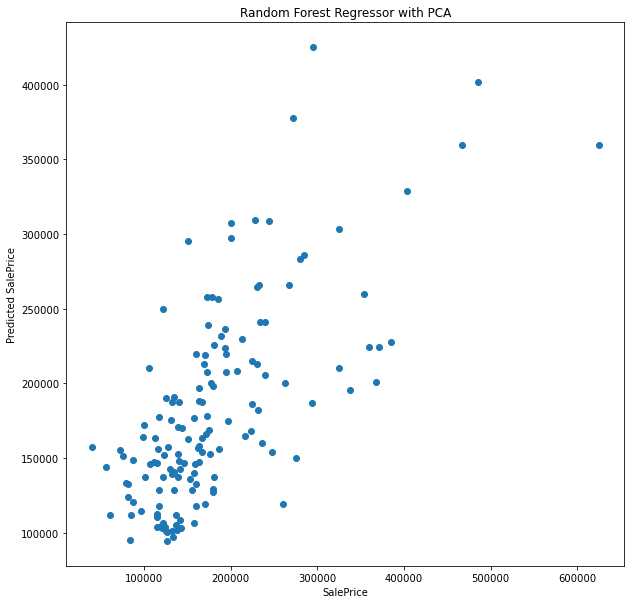

RMSE (Random Forest Regressor) =  63020.83153741787


In [27]:

def PCA_Final():   
 

    PCA_2D = PCA(n_components=6)

    PCA_transformed=PCA_2D.fit_transform(df_PCA_numeric_train2)

    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle('Sale Price Vs X_train PCA Transformations')
    axes[0, 0].plot(PCA_transformed[:,0],df_SalePrice_train, 'bo',markersize=2)
    axes[0, 0].set_title('PCA0')
    
    axes[0, 1].plot(PCA_transformed[:,1],df_SalePrice_train, 'bo',markersize=2)
    axes[0, 1].set_title('PCA1')


    axes[1, 0].plot(PCA_transformed[:,2],df_SalePrice_train, 'bo',markersize=2)
    axes[1, 0].set_title('PCA2')


    axes[1, 1].plot(PCA_transformed[:,3],df_SalePrice_train, 'bo',markersize=2)
    axes[1, 1].set_title('PCA3')
    
    axes[2, 0].plot(PCA_transformed[:,4],df_SalePrice_train, 'bo',markersize=2)
    axes[2, 0].set_title('PCA4')
    
    axes[2, 1].plot(PCA_transformed[:,5],df_SalePrice_train, 'bo',markersize=2)
    axes[2, 1].set_title('PCA5')
    
    for ax in axes.flat:
        ax.set(ylabel='Sale Price')
    
    plt.show()
    print('========================================================================================')
    print('')
    
    #print(PCA_transformed)
    
    df_X_processed = pd.DataFrame(PCA_transformed, columns = ['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5'])
    #print(df_X_processed)
    
    #print(df_SalePrice_train)
    
    
    
    PCA_transformed_test=PCA_2D.fit_transform(df_PCA_numeric_test2)

    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle('Sale Price Vs X_test PCA Transformations')
    axes[0, 0].plot(PCA_transformed_test[:,0],df_SalePrice_test, 'bo',markersize=2)
    axes[0, 0].set_title('PCA0')
    
    axes[0, 1].plot(PCA_transformed_test[:,1],df_SalePrice_test, 'bo',markersize=2)
    axes[0, 1].set_title('PCA1')


    axes[1, 0].plot(PCA_transformed_test[:,2],df_SalePrice_test, 'bo',markersize=2)
    axes[1, 0].set_title('PCA2')


    axes[1, 1].plot(PCA_transformed_test[:,3],df_SalePrice_test, 'bo',markersize=2)
    axes[1, 1].set_title('PCA3')
    
    axes[2, 0].plot(PCA_transformed_test[:,4],df_SalePrice_test, 'bo',markersize=2)
    axes[2, 0].set_title('PCA4')
    
    axes[2, 1].plot(PCA_transformed_test[:,5],df_SalePrice_test, 'bo',markersize=2)
    axes[2, 1].set_title('PCA5')
    
    for ax in axes.flat:
        ax.set(ylabel='Sale Price')
    
    plt.show()
    print('========================================================================================')
    print('')
    
    #print(PCA_transformed_test)
    
    df_X_processed_test = pd.DataFrame(PCA_transformed_test, columns = ['PCA0','PCA1','PCA2','PCA3','PCA4','PCA5'])
    #print(df_X_processed_test)
    
    
    
    X_train, X_test, y_train, y_test = df_X_processed, df_X_processed_test,df_SalePrice_train,df_SalePrice_test
    regressor = RandomForestRegressor()
    regressor.fit(X_train, y_train)

    # plot dignostics
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_test, regressor.predict(X_test))
    plt.title('Random Forest Regressor with PCA')
    plt.xlabel('SalePrice')
    plt.ylabel('Predicted SalePrice')
    
    plt.show()
    print('========================================================================================')
    print('RMSE (Random Forest Regressor) = ',mean_squared_error(y_test, regressor.predict(X_test), squared=False))
    print('========================================================================================')



PCA_Final()